# WHOBS-IE-100
## Notionally Optimal, 100% Wind+Hydrogen+Other+Battery+Solar Electricity System for Ireland (IE)

- **Project:** [OESM-IE](http://ecrn.eeng.dcu.ie/projects/oesm-ie)
- **Funding:** [Sustainable Energy Authority of Ireland (SEAI) Research, Development and Demonstration Programme](https://www.seai.ie/grants/research-funding/research-development-and-demonstration-fund/), award reference SEAI RDD/00246 2018.
- **Author:** Barry McMullin, barry.mcmullin@dcu.ie
- **Last modified:** 03 June 2020
- **© 2020:** [Dublin City University](http://www.dcu.ie/)
- **Licence:** [GNU GENERAL PUBLIC LICENSE Version 3](https://www.gnu.org/licenses/gpl-3.0.en.html)

This is a derived from: [Optimal Wind+Hydrogen+Other+Battery+Solar (WHOBS) electricity systems for European countries](https://github.com/PyPSA/WHOBS)

Download the [Jupyter notebook](https://jupyter.org/) at: **TODO**


## Introduction/motivation

[WHOBS](https://github.com/PyPSA/WHOBS), and the associated interactive web application [model.energy](https://model.energy/), allows modelling of notionally optimised "firm" electricity generation for a given level of (constant/"baseload") capacity, based exclusively on *variable* renewable (VRE: here limited to wind and solar) sources, coupled with hydrogen and/or battery storage (to cover "when the wind doesn't blow and the sun doesn't shine"). 

Wind and solar resource variability is configured for states within Europe using historical data from [Renewables.ninja](https://www.renewables.ninja/) ([model.energy](https://model.energy/) extends this coverage to global geographical locations using other data sources).

**WHOBS-IE-100** adapts WHOBS to model delivery of **100%** of electricity demand for one particular European country (**Ireland**), based on [historical load data](http://www.eirgridgroup.com/how-the-grid-works/renewables/) from the [Irish Transmission System Operator (TSO) eirgrid](http://www.eirgridgroup.com/).

This result illustrates the (rough) trade-off between:

- Raw VRE *overprovision* (building more VRE capacity than can be directly dispatched at all times, but meaning that more demand can be covered directly by instantaneous VRE generations)
- Dispatch down (discarding some generation when it is in excess of instantaneous load)
- Storage (storing some generation when it is in excess of instantaneous load)
    - Short term, high efficiency storage: battery
    - Long term, low efficiency storage: hydrogen

This toy model assumes a completely isolated grid (no external interconnection).


## TODO

+ Create/release as github project: add link in metadata block at top?
+ Link to the [detailed caveats in the WHOBS README](https://github.com/PyPSA/WHOBS#warnings).
+ Add more cautions/, including:
    - *multi-annual* variability in generation and load
    - constraint as well as curtailment 
    - system stability (traditional SNSP!) 
    - onshore wind only (offshore would be less variable but generally still more expensive)
    - limited/no salt cavern underground storage within the IE jurisdiction (there is some in NI, but [currently targetted for NG storage!](https://www.infrastrataplc.com/projects/islandmagee-energy/)
    - unclear whether the proposed (solved) wind and solar capacity is even feasible within the jurisdiction
    - certain "low carbon", "firm" generation sources are deliberately omitted: nuclear, fossil fuel with CCS and bioenergy: it is likely that a (near) zero-$CO_2$ system could be achieved at lower cost by allowing such a wider range of options
    - etc. etc...
+ Batteries are allowed a tech-generic lifetime of 25 years (in assumptions .csv) - which seems a bit generous? Though may not change the results all that much...
+ Add some (simplistic) model of interconnection: e.g. as a `StorageUnit` with `cyclic=True`, fixed `p_nom`, efficiency somewhat reflective of real IC losses (to UK/France). This is easier than trying to pick a price for a market import/export model (though it excludes nett exports as a trade opportunity...). Skates over the NI integration connection, which arguably deserves finer grained representation (given similar wind var profile).
+ Add some representation of offshore wind as well as onshore; set `p_nom_extendable_max` for onshore, based on actual SEAI estimates. Note that offshore variability pattern is expected to be different from onshore (potential high capacity factor, absent dispatch down).
+ Add some notional representation of grid losses (matching typical SEAI/Eirgrid levels?).
+ Add some crude capability of changing average load level for target year (linear, exponential, whatever...)
+ Add more flexible options on temporal resolution - not just 1 or 3 hours, but 6, 12, 24 hours?
+ Add H2P OCGT (as well as CCGT)? Let `lopf()` optimise between OCGT and CCGT (will it all go to one?).
+ Instead of a H2 steel tank storage being binary, leave it available unconditionally, but (optionally) set an `e_extendable_max` limit on H2 salt cavern underground storage (possibly loosely based on actual geology available in NI).
+ Add a "middle tier" H2 storage option (between steel tank and salt cavern underground): [loosely based on ammonia tank storage](https://ammoniaindustry.com/ammonia-for-energy-storage-economic-and-technical-analysis/)?
+ Of course, extending into heating and transport sectors is also on the agenda!
+ Refactor the "scenario" concept:
    - Incorporate `frequency` (properly, `time_resolution` or `time_step` or `snapshot_interval`?).
    - Incorporate dispatch priority among VRE (solar/wind) as a scenario variable
    - Currently "hydrogen" and "hydrogen steel tank" are effectively boolean scenario variables, though not expressly incorporated in the scenario mechanism/naming. Maybe make "all" the discrete technologies boolean in this sense, with a scenario tech substring something like: `WSHTB` (Wind|Solar|H2|Tank|Battery)?
    - Refactor so that generic `network` only constructed once, and then specific details varied by scenario; should yield a little performance improvement/responsivity...
+ Possibly refactor to remove the `ct` ("country"?) use? This is inherited from WHOBS, which genuinely has configuration capability for a variety of countries; but WHOBS-IE-100 really is hard-wired already for IE?
+ Figure out/refactor exactly the way the plotting works...
+ Refactor the import of third-party data files (Renewables.ninja and Eirgrid) to automate, with local caching...
+ Create a single line diagram illustration (SLD)
+ Screencast tutorial/explanation?


In [1]:
import pypsa
import numpy as np
import pandas as pd
idx = pd.IndexSlice

import matplotlib.pyplot as plt
from pyomo.environ import Constraint

%matplotlib inline

In [2]:
def fmt_float(x) :
    return (F"{x: 6.2f}")
    
pd.set_option('float_format', fmt_float)

In [3]:
# Initialise empty DataFrame to collect run configuration
run_configs = pd.DataFrame()

# Initialise empty DataFrame to collect run output stats
run_stats = pd.DataFrame()

In [4]:
# Set plotsize in notebook
# https://www.mikulskibartosz.name/how-to-change-plot-size-in-jupyter-notebook/
plt.rcParams["figure.figsize"] = (12,6) 

## Major configuration settings

In [5]:
# WHOBS was generic to multiple countries coded by `ct`; but here we will be 
# hard-wired to `IE` in other ways, so set `ct` to match in (legacy) WHOBS code.
# Essential usage is to index into renewables.ninja datasets.

ct = "IE"
solver_name = "cbc"

## Required data

### Wind and solar resource variabilities

From [Renewables.ninja Downloads](https://www.renewables.ninja/downloads):

- Solar time series "ninja_pv_europe_v1.1_sarah.csv" from [PV v1.1 Europe (.zip)](https://www.renewables.ninja/static/downloads/ninja_europe_pv_v1.1.zip)
- Wind time series "ninja_wind_europe_v1.1_current_on-offshore.csv" from [Wind v1.1 Europe (.zip)](https://www.renewables.ninja/static/downloads/ninja_europe_wind_v1.1.zip)

### IE Load (electricity demand) variability

From [eirgrid System and Renewable Data Reports](http://www.eirgridgroup.com/how-the-grid-works/renewables/):

- [System-Data-Qtr-Hourly-2018-2019.xlsx](http://www.eirgridgroup.com/site-files/library/EirGrid/System-Data-Qtr-Hourly-2018-2019.xlsx) 
- [System-Data-Qtr-Hourly-2016-2017.xlsx](http://www.eirgridgroup.com/site-files/library/EirGrid/System-Data-Qtr-Hourly-2016-2017.xlsx)
- [System-Data-Qtr-Hourly-2014-2015.xlsx](http://www.eirgridgroup.com/site-files/library/EirGrid/System-Data-Qtr-Hourly-2014-2015.xlsx)


## Read in wind and solar variability data

**TODO:** Ideally, recode this to check for local copy, and, if not available, automatically download 
and extract the required .csv from the .zip in each case; but for the moment, just assume there is are local copies of the .csv files already available.

**Alternative approach?** An alterative to using renewables ninja (specfically for wind) would be to extract the variability data (of actual wind generation) from historical eirgrid data. This would reflect the performance of the IE wind fleet as of whatever historical date was used: which may be a good thing or a bad thing of course (since that is almost 100% onshore for the moment, it is "biased against" offshore - arguably?).


In [6]:
#rninja_base_url = "https://www.renewables.ninja/static/downloads/"
r_ninja_base_url = 'ninja/' # Actually already downloaded...

In [7]:
#solar_pv_zip_file = 'ninja_europe_pv_v1.1.zip'
#solar_pv_zip_url = r_ninja_base_url + solar_pv_zip_file

solar_pv_csv_file = 'ninja_pv_europe_v1.1_sarah.csv'
solar_pv_csv_url = r_ninja_base_url + solar_pv_csv_file

#read in renewables.ninja solar time series
solar_pu_raw = pd.read_csv(solar_pv_csv_url,
                       index_col=0,parse_dates=True)

In [8]:
#wind_zip_file = 'ninja_europe_wind_v1.1.zip'
#wind_zip_url = r_ninja_base_url + wind_zip_file

wind_csv_file = 'ninja_wind_europe_v1.1_current_on-offshore.csv'
wind_csv_url = r_ninja_base_url + wind_csv_file

#read in renewables.ninja wind time series
wind_pu_raw = pd.read_csv(wind_csv_url,
                       index_col=0,parse_dates=True)

## Read in and preprocess load variability data (via Ireland TSO, [EirGrid](http://www.eirgridgroup.com/))

We start with [historical data inputs from EirGrid](http://www.eirgridgroup.com/how-the-grid-works/renewables/) which show 15-minute time series for:

- wind availability
- wind generation
- total generation
- total load

broken out by:

- IE (Republic of Ireland) only
- NI (Northern Ireland) only

As this particular notebook in only relying on this data for an example of "typical" annual variability in aggregate load we select the data for **IE (Republic of Ireland) only**.

In [15]:
# Retrieve example eirgrid load data into a pd.DataFrame

# If file already available locally, can point at that; otherwise use the web url
# (i.e. uncomment one or the other of the following two statements).

#eirgrid_base_url = "http://www.eirgridgroup.com/site-files/library/EirGrid/"
eirgrid_base_url = "eirgrid/"

# Columns of interest:
cols = ['DateTime', 'GMT Offset', "IE Demand"]

load_data_raw = pd.DataFrame()
for base_year in [2014, 2016, 2018] :
    load_data_filename = F"System-Data-Qtr-Hourly-{base_year:4}-{(base_year+1):4}.xlsx"
    load_data_url = eirgrid_base_url + load_data_filename
    load_data_raw = pd.concat([load_data_raw, pd.read_excel(load_data_url, usecols = cols)], axis=0)

display(load_data_raw)

,DateTime,GMT Offset,IE Demand
0,2014-01-01 00:00:00,0,2898.72
1,2014-01-01 00:15:00,0,2868.97
2,2014-01-01 00:30:00,0,2826.42
3,2014-01-01 00:45:00,0,2786.94
4,2014-01-01 01:00:00,0,2723.94
...,...,...,...
70075,2019-12-31 22:45:00,0,3049.42
70076,2019-12-31 23:00:00,0,3124.04
70077,2019-12-31 23:15:00,0,3131.26
70078,2019-12-31 23:30:00,0,3111.32


## Fix the timestamps...

The raw eirgrid data has one column showing localtime (`DateTime`, type `pd.Timestamp`, holding "naive" timestamps - no recorded timezone) and a separate column showing the offset, in hours, from UTC for each individual row (`GMT Offset`). It will be simpler here to convert all the `DateTime` values to UTC (and explicitly having the UTC timezone).

We can then dispense with the `GMT Offset` column as it is redundant.

In [18]:
from datetime import timedelta

def tz_fix(row):
  try:
    naive_timestamp = row['DateTime']
    gmt_offset = row['GMT Offset'] 
    utc_timestamp = naive_timestamp - timedelta(hours=float(gmt_offset))
        # float() conversion required for timedelta() argument!
        # Must SUBTRACT the GMT Offset to get GMT/UTC
    row['DateTime'] = utc_timestamp.tz_localize('UTC')
  except Exception as inst:
    print(F"Exception:\n {row}")
    print(inst)
  return row

# This may be rather be slow for a big dataset...
load_data_raw = load_data_raw.apply(tz_fix, axis=1).drop(columns='GMT Offset')

load_data_raw.set_index('DateTime', verify_integrity=True, inplace=True)

## Data quality checks?

Minimal data quality check: make sure [we have no missing values](https://chartio.com/resources/tutorials/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe/) (either `None` or `NaN`).

In [23]:
assert(not load_data_raw.isnull().values.any())

## Show some (raw) load profile stats

In [24]:
load_raw = load_data_raw.loc[:,'IE Demand'] # convert to pd.Series

load_raw_max = load_raw.max()
load_raw_mean = load_raw.mean()
load_raw_min = load_raw.min()
load_raw_e = load_raw.sum()*0.25 # Raw time interval is 15m == 0.25h

display(load_raw)
print(F"load_raw_max: {(load_raw_max/1.0e3) : 6.3f} GW")
print(F"load_raw_mean: {(load_raw_mean/1.0e3) : 6.3f} GW")
print(F"load_raw_min: {(load_raw_min/1.0e3) : 6.3f} GW")
print(F"load_raw_e: {(load_raw_e/1.0e6) : 6.3f} TWh")

DateTime
2014-01-01 00:00:00+00:00    2898.72
2014-01-01 00:15:00+00:00    2868.97
2014-01-01 00:30:00+00:00    2826.42
2014-01-01 00:45:00+00:00    2786.94
2014-01-01 01:00:00+00:00    2723.94
                              ...   
2019-12-31 22:45:00+00:00    3049.42
2019-12-31 23:00:00+00:00    3124.04
2019-12-31 23:15:00+00:00    3131.26
2019-12-31 23:30:00+00:00    3111.32
2019-12-31 23:45:00+00:00    3074.44
Name: IE Demand, Length: 210240, dtype: float64

load_raw_max:  5.014 GW
load_raw_mean:  3.142 GW
load_raw_min:  1.664 GW
load_raw_e:  165.142 TWh


## Required functions

In [25]:
# FIXME: need some docs/explanation/sources for this calculation?

def annuity(lifetime, rate):
    if rate == 0.0 :
        return 1.0/lifetime
    else:
        return rate/(1.0 - (1.0 / (1.0 + rate)**lifetime))

In [26]:
def prepare_assumptions(Nyears=1,usd_to_eur=1/1.2,assumptions_year=2020):
    """set all asset assumptions and other parameters"""

    assumptions = pd.read_csv("assumptions.csv",index_col=list(range(3))).sort_index()

    #correct units to MW and EUR
    assumptions.loc[assumptions.unit.str.contains("/kW"),"value"]*=1e3
    assumptions.loc[assumptions.unit.str.contains("USD"),"value"]*=usd_to_eur

    assumptions = assumptions.loc[idx[:,assumptions_year,:],
                                  "value"].unstack(level=2).groupby(level="technology").sum(min_count=1)

    #fill defaults
    assumptions = assumptions.fillna({"FOM" : assumptions.at["default","FOM"],
                                      "discount rate" : assumptions.at["default","discount rate"],
                                      "lifetime" : assumptions.at["default","lifetime"]})

    #annualise investment costs, add FOM
    # (FOM = estimated "Follow On Maintenance", as % of initial capex, per annum?)
    assumptions["fixed"] = [(annuity(v["lifetime"],v["discount rate"]) + 
                             v["FOM"]/100.)*v["investment"]*Nyears for i,v in assumptions.iterrows()]

    return assumptions

In [58]:
def solve_network(run_id):

    snapshot_interval = int(run_configs.loc['snapshot_interval',run_id])
    Nyears = int(run_configs.loc['Nyears',run_id])

    # Available year(s) for weather data: solar 1985-2015 inclusive, wind 1980-2016
    weather_year_start = int(run_configs.loc['weather_year_start',run_id])
    assert(weather_year_start >= 1985)
    weather_year_end = weather_year_start + (Nyears - 1)
    assert(weather_year_end <= 2015)

    # Available year(s) for IE load data: 2014-2019 inclusive
    load_year_start = int(run_configs.loc['load_year_start',run_id])
    assert(load_year_start >= 2014)
    load_year_end = load_year_start + (Nyears - 1)
    assert(load_year_end <= 2019)
    
    load_date_start = "{}-01-01 00:00".format(load_year_start)
    load_date_end = "{}-12-31 23:59".format(load_year_end)
    load = load_raw.loc[load_date_start:load_date_end]
#    print(load_date_start)
#    print(load_date_end)
#    display(load)

    solar_pu = solar_pu_raw.resample(str(snapshot_interval)+"H").mean()
    wind_pu = wind_pu_raw.resample(str(snapshot_interval)+"H").mean()
    load = load.resample(str(snapshot_interval)+"H").mean()
    # All this (re-)sampling will be a bit inefficient if doing multiple runs with the 
    # same snapshot_interval; but for the moment at least, we don't try to optimise around that
    # (e.g. by caching resampled timeseries for later use...)

#    display(load_data_raw)  
    
#    display(load)

    assumptions_year = int(run_configs.loc['assumptions_year',run_id])
    assert (assumptions_year in [2020, 2030, 2050])
    assumptions = prepare_assumptions(Nyears=Nyears,
                                      assumptions_year=assumptions_year,
                                      usd_to_eur=run_configs.loc['usd_to_eur',run_id])

    network = pypsa.Network()

    snaps_df = pd.date_range("{}-01-01".format(weather_year_start),
                              "{}-12-31 23:00".format(weather_year_end),
                              freq=str(snapshot_interval)+"H").to_frame()

    snapshots = snaps_df[~((snaps_df.index.month == 2) & (snaps_df.index.day == 29))].index
    load = load[~((load.index.month == 2) & (load.index.day == 29))]
    # Kludge to filter out "leap days" (29th Feb in any year)
    # https://stackoverflow.com/questions/34966422/remove-leap-year-day-from-pandas-dataframe
    # Necessary because we will want to align arbitrary load years with arbitrary weather years...

    # Kludge to filter out "leap days" (29th Feb in any year)

    display(snapshots)
    assert(load.count() == snapshots.size)
    
    network.set_snapshots(snapshots)

    network.snapshot_weightings = pd.Series(float(snapshot_interval),index=network.snapshots)

    network.add("Bus",ct)
    network.add("Load",ct,
                bus=ct,
                p_set= load.values)

    network.add("Generator",ct+" solar",
                bus=ct,
                p_max_pu = solar_pu[ct],
                p_nom_extendable = True,
                p_nom_max = run_configs.at['solar_max_p (GW)', run_id]*1e3, #GW -> MW
                marginal_cost = 0.02, 
                #Small cost to prefer curtailment to destroying energy in storage, wind curtails before solar
                capital_cost = assumptions.at['utility solar PV','fixed'],
                #p_nom_max = 0.0
               )

    network.add("Generator",ct+" wind",
                bus=ct,
                p_max_pu = wind_pu[ct+"_ON"],
                p_nom_extendable = True,
                p_nom_max = run_configs.at['wind_max_p (GW)', run_id]*1e3, #GW -> MW
                marginal_cost = 0.01, 
                #Small cost to prefer curtailment to destroying energy in storage, wind curtails before solar
                capital_cost = assumptions.at['onshore wind','fixed'])
    
    
 
    network.add("Bus",ct + " battery")

    network.add("Store",ct + " battery storage",
                bus = ct + " battery",
                e_nom_extendable = True,
                e_cyclic=True,
                capital_cost=assumptions.at['battery storage','fixed'])

    network.add("Link",ct + " battery charge",
                bus0 = ct,
                bus1 = ct + " battery",
                efficiency = assumptions.at['battery inverter','efficiency'],
                p_nom_extendable = True,
                capital_cost=assumptions.at['battery inverter','fixed'])

    network.add("Link",ct + " battery discharge",
                bus0 = ct + " battery",
                bus1 = ct,
                p_nom_extendable = True,
                efficiency = assumptions.at['battery inverter','efficiency'])

    def extra_functionality(network,snapshots):
        def battery(model):
            return (model.link_p_nom[ct + " battery charge"] 
                    == model.link_p_nom[ct + " battery discharge"]*network.links.at[ct 
                    + " battery charge","efficiency"])

        network.model.battery = Constraint(rule=battery)

    network.add("Bus",
                     ct + " H2",
                     carrier="H2")

    network.add("Link",
                    ct + " H2 electrolysis",
                    bus1=ct + " H2",
                    bus0=ct,
                    p_nom_extendable=True,
                    efficiency=assumptions.at["H2 electrolysis","efficiency"],
                    capital_cost=assumptions.at["H2 electrolysis","fixed"])

    network.add("Link",
                     ct + " H2 to power",
                     bus0=ct + " H2",
                     bus1=ct,
                     p_nom_extendable=True,
                     efficiency=assumptions.at["H2 CCGT","efficiency"],
                     capital_cost=assumptions.at["H2 CCGT","fixed"]*assumptions.at["H2 CCGT","efficiency"])  
                     #NB: fixed cost is per MWel

    network.add("Store",
                     ct + " H2 store underground",
                     bus=ct + " H2",
                     e_nom_extendable=True,
                     e_nom_max = run_configs.loc['h_store_underground_max_e (TWh)',run_id]*1.0e6,
                         # TWh -> MWh
                     e_cyclic=True,
                     capital_cost=assumptions.at["H2 underground storage","fixed"])

    network.add("Store",
                     ct + " H2 store tank",
                     bus=ct + " H2",
                     e_nom_extendable=True,
                     e_nom_max = run_configs.loc['h_store_tank_max_e (TWh)',run_id]*1.0e6, 
                         # TWh -> MWh
                     e_cyclic=True,
                     capital_cost=assumptions.at["H2 steel tank storage", "fixed"])



    if solver_name == "gurobi":
        solver_options = {"threads" : 4,
                          "method" : 2,
                          "crossover" : 0,
                          "BarConvTol": 1.e-5,
                          "FeasibilityTol": 1.e-6 }
    else:
        solver_options = {}


    network.consistency_check()

    network.lopf(solver_name=solver_name,
                 solver_options=solver_options,
                 extra_functionality=extra_functionality)

    return network

In [36]:
def gather_run_stats(run_id,network):
    
    snapshot_interval = run_configs.at['snapshot_interval',run_id]
    
    total_load_e = (network.loads_t.p.sum().sum() * snapshot_interval)
    available_e = (network.generators_t.p_max_pu.multiply(network.generators.p_nom_opt).sum() 
        * snapshot_interval)
    total_available_e = available_e.sum()
    dispatched_e = network.generators_t.p.sum() * snapshot_interval
    total_dispatched_e = dispatched_e.sum()
    undispatched_e = (available_e - dispatched_e)
    total_undispatched_e = undispatched_e.sum()
    undispatched_frac = undispatched_e/available_e
    
    run_stats.at["System load (TWh)",run_id] = total_load_e/1.0e6
    run_stats.at["System available (TWh)",run_id] = total_available_e/1.0e6
    run_stats.at["System efficiency gross (%)",run_id] = (total_load_e/total_available_e)*100.0
        # "gross" includes dispatch down
    run_stats.at["System dispatched (TWh)",run_id] = total_dispatched_e/1.0e6
    run_stats.at["System dispatched down (TWh)",run_id] = total_undispatched_e/1.0e6
    run_stats.at["System storage loss (TWh)",run_id] = (total_dispatched_e-total_load_e)/1.0e6

    run_stats.at["System efficiency net (%)",run_id] = (total_load_e/total_dispatched_e)*100.0
        # "net" of dispatch down
    run_stats.at["System LCOE (€/MWh)",run_id] = network.buses_t.marginal_price.mean()[ct]

    total_hours = network.snapshot_weightings.sum()
    
    gens = ["wind","solar"]
    for g in gens:
        g_idx = ct + " " + g
        run_stats.at[g+" capacity nom (GW)",run_id] = (
            network.generators.p_nom_opt[g_idx]/1.0e3)
        run_stats.at[g+" available (TWh)",run_id] = available_e[g_idx]/1.0e6
        run_stats.at[g+" dispatched (TWh)",run_id] = dispatched_e[g_idx]/1.0e6
        run_stats.at[g+" penetration (%)",run_id] = (dispatched_e[g_idx]/total_dispatched_e)*100.0 
        run_stats.at[g+" dispatched down (TWh)",run_id] = (undispatched_e[g_idx])/1.0e6
        run_stats.at[g+" dispatched down (%)",run_id] = (undispatched_frac[g_idx])*100.0
        run_stats.at[g+" capacity factor max (%)",run_id] = (
            network.generators_t.p_max_pu[g_idx].mean())*100.0
        run_stats.at[g+" capacity factor act (%)",run_id] = (
            dispatched_e[g_idx]/(network.generators.p_nom_opt[g_idx]*total_hours))*100.0
        
    run_stats.at["Battery charge/discharge (MW)",run_id] = network.links.p_nom_opt[ct + " battery charge"]
        # NB: battery charge are discharge p_nom are constrained to be equal, modulo efficiency
    run_stats.at["Battery storage (MWh)",run_id] = network.stores.e_nom_opt[ct + " battery storage"]
    run_stats.at["P2H (electrolysis, GW)",run_id] = (network.links.p_nom_opt[ct + " H2 electrolysis"]/1.0e3)
    run_stats.at["H2P (H2 CCGT, GW)",run_id] = (network.links.p_nom_opt[ct + " H2 to power"]/1.0e3)
    run_stats.at["H2 store underground (TWh)",run_id] = (network.stores.e_nom_opt[ct + " H2 store underground"]/1.0e6)
    run_stats.at["H2 store tank (TWh)",run_id] = (network.stores.e_nom_opt[ct + " H2 store tank"]/1.0e6)

    return run_stats

## Solve the system (interactive/single-shot)

In [29]:
# Uncomment and run this if/when desired to clear the accumulated run_configs and run_stats

# FIXME: would like to have any way to shovel these result checkpoints out to 
# an external (persistent) data file?

run_configs=pd.DataFrame()
run_stats=pd.DataFrame() 

In [82]:
# Actually hardwired: ct='IE', wind dispatch priority, 

run_id = 'Test 002'

# Note that pandas will tend to default to a float dtype throughout, even when an int is provided; 
# best coerce back to int on use, whenever needed, if important.
run_configs.at['snapshot_interval', run_id] = 24 # hours
# Available year(s) for weather data: solar 1985-2015 inclusive, wind 1980-2016
run_configs.at['weather_year_start', run_id] = 2008 
# Available year(s) for IE load data: 2014-2019 inclusive
run_configs.at['load_year_start', run_id] = 2014
run_configs.at['Nyears', run_id] = 6
run_configs.at['assumptions_year', run_id] = 2030 # Used to select projected nominal cost 
run_configs.at['usd_to_eur', run_id] = 0.90 
run_configs.at['wind_max_p (GW)', run_id] = +np.inf
run_configs.at['solar_max_p (GW)', run_id] = 5
run_configs.at['h_store_underground_max_e (TWh)', run_id] = 3.0
run_configs.at['h_store_tank_max_e (TWh)', run_id] = 1.0 

display(run_configs)

,Test 000,Test 001,Test 002
snapshot_interval,24.00,24.00,24.00
weather_year_start,2008.00,2008.00,2008.00
load_year_start,2014.00,2014.00,2014.00
Nyears,6.00,6.00,6.00
assumptions_year,2030.00,2030.00,2030.00
usd_to_eur,0.90,0.90,0.90
h_store_underground_max_e (TWh),inf,3.00,3.00
h_store_tank_max_e (TWh),1.00,1.00,1.00
wind_max_p (GW),inf,inf,inf
solar_max_p (GW),5.00,5.00,5.00


In [83]:
network = solve_network(run_id)

DatetimeIndex(['2008-01-01', '2008-01-02', '2008-01-03', '2008-01-04',
               '2008-01-05', '2008-01-06', '2008-01-07', '2008-01-08',
               '2008-01-09', '2008-01-10',
               ...
               '2013-12-22', '2013-12-23', '2013-12-24', '2013-12-25',
               '2013-12-26', '2013-12-27', '2013-12-28', '2013-12-29',
               '2013-12-30', '2013-12-31'],
              dtype='datetime64[ns]', length=2190, freq=None)

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using cbc
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 14276569510.0
  Upper bound: 14276569510.0
  Number of objectives: 1
  Number of constraints: 52562
  Number of variables: 26290
  Number of nonzeros: 4388
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 3.05
  Wallclock time: 3.79
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: Non

In [84]:
gather_run_stats(run_id,network)
display(run_stats)

,Test 000,Test 001,Test 002
System load (TWh),165.14,165.14,165.14
System available (TWh),217.74,216.53,248.23
System efficiency gross (%),75.84,76.27,66.53
System dispatched (TWh),195.26,193.45,188.61
System dispatched down (TWh),22.47,23.08,59.62
System storage loss (TWh),30.12,28.31,23.47
System efficiency net (%),84.57,85.37,87.56
System LCOE (€/MWh),83.97,84.27,96.50
wind capacity nom (GW),11.36,12.73,14.86
wind available (TWh),169.08,189.56,221.26


## Some one-off plotting (most recent `run_id`)

In [85]:
Nyears = int(run_configs.loc['Nyears',run_id])
weather_year_start = int(run_configs.loc['weather_year_start',run_id])
weather_year_end = weather_year_start + (Nyears - 1)

plt_start = F"{weather_year_start}-01-01"
plt_stop = F"{weather_year_end}-12-31"

<IPython.core.display.Javascript object>


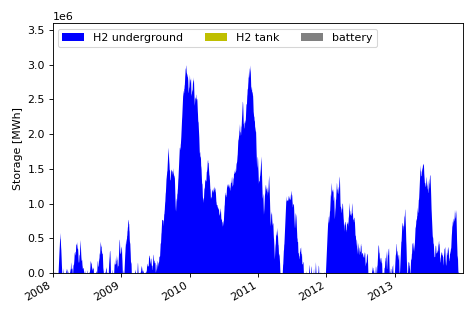

,H2 underground,H2 tank,battery
2008-01-01,0.00,0.00,0.00
2008-01-02,0.00,0.00,0.00
2008-01-03,0.00,0.00,0.00
2008-01-04,0.00,0.00,0.00
2008-01-05,0.00,0.00,0.00
...,...,...,...
2013-12-27,0.00,0.00,0.00
2013-12-28,0.00,0.00,0.00
2013-12-29,0.00,0.00,0.00
2013-12-30,0.00,0.00,0.00


[-6714.8052541667, 6714.8053]


In [86]:
%matplotlib notebook

fig, ax = plt.subplots()
#fig.set_size_inches((10,8))

"H2 store underground"
"H2 store tank"
"battery storage"

rename = {"H2 store underground" : "H2 underground",
          "H2 store tank" : "H2 tank",
          "battery storage" : "battery"}

rename = {ct + " "+k : v for k,v in rename.items()}

colors = {"H2 underground" : "b",
           "H2 tank" : "y",
           "battery" : "gray"}

storage = network.stores_t.e[[ct+" H2 store underground",
                              ct+" H2 store tank",ct+" battery storage"]].rename(columns=rename).round(10)
display(storage)

storage.loc[start:stop].plot(kind="area",stacked=True,ax=ax,linewidth=0,
                              color=[colors[i] for i in storage.columns])

e_max = storage.sum(axis=1).max()
e_min = storage.sum(axis=1).min()

#ax.set_ylim([demand_max,gen_max])
print([demand_max,gen_max])
ax.set_ylim([0.0, 1.2*e_max])
ax.set_xlim([plt_start,plt_stop])
ax.set_ylabel("Storage [MWh]")
ax.legend(ncol=3,loc="upper left")

fig.tight_layout()

#fig.savefig("img/{}-{}-{}-{}.png".format(ct,scenario,start,stop),dpi=100)

<IPython.core.display.Javascript object>


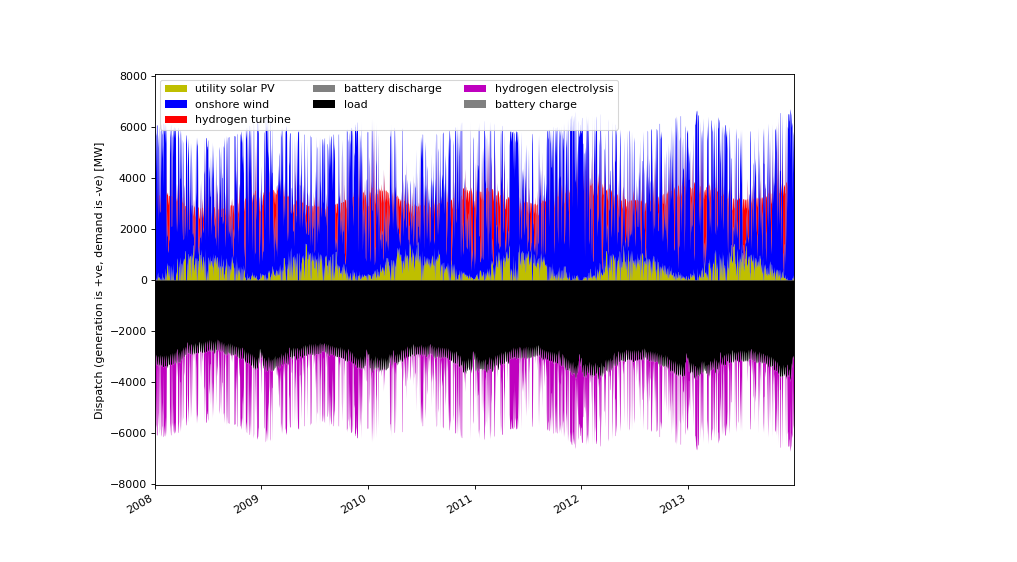

False
[-6714.8052541667, 6714.8053]


/home/mcmullib/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1282: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


In [71]:
%matplotlib notebook

fig, ax = plt.subplots()
#fig.set_size_inches((10,8))


rename = {"wind" : "onshore wind",
          "solar" : "utility solar PV",
          "battery discharge" : "battery discharge",
          "battery charge" : "battery charge",
          "H2 electrolysis" : "hydrogen electrolysis",
          "H2 to power" : "hydrogen turbine"}

rename = {ct + " "+k : v for k,v in rename.items()}

rename[ct] = "load"

colors = {"onshore wind" : "b",
           "utility solar PV" : "y",
           "battery discharge" : "gray",
           "battery charge" : "gray",
           "load" : "k",
           "hydrogen electrolysis" : "m",
           "hydrogen turbine" : "r"
          }


# FIXME: for some reason (solver tolerance?) some solution values that should be strictly 
# positive or negative may be infinitesimally (< 10e-10) of the other sign. This will cause 
# df.plot(stacked=True) to throw an error (requires all values to have same sign, positive or 
# negative). So we do an ugly ".round(10)" to fix it...

positive = pd.concat((network.generators_t.p,-network.links_t.p1[[ct+" H2 to power",ct+" battery discharge"]]),
                     axis=1).rename(columns=rename).round(10)
negative = pd.concat((-network.loads_t.p,-network.links_t.p0[[ct+" H2 electrolysis",ct+" battery charge"]]),
                     axis=1).rename(columns=rename).round(10)

print((abs(positive.sum(axis=1) + negative.sum(axis=1)) > 0.1).any())

positive.loc[start:stop].plot(kind="area",stacked=True,ax=ax,linewidth=0,
                              color=[colors[i] for i in positive.columns])

negative.loc[start:stop].plot(kind="area",stacked=True,ax=ax,linewidth=0,
                              color=[colors[i] for i in negative.columns])

gen_max=positive.sum(axis=1).max()
demand_max=negative.sum(axis=1).min()

#ax.set_ylim([demand_max,gen_max])
print([demand_max,gen_max])
ax.set_ylim([1.2*demand_max, 1.2*gen_max])
ax.set_xlim([plt_start,plt_stop])
ax.set_ylabel("Dispatch (generation is +ve, demand is -ve) [MW]")
ax.legend(ncol=3,loc="upper left")

fig.tight_layout()

#fig.savefig("img/{}-{}-{}-{}.png".format(ct,scenario,start,stop),dpi=100)

## Solve a single year for various time resolutions (`snapshot_interval`)

In [ ]:
run_configs = pd.DataFrame()
run_id_stem = 'SI-'

for snapshot_interval in [1, 3, 6, 12, 24] :
    run_id = run_id_stem+str(snapshot_interval)+"H"
    run_configs.at['snapshot_interval', run_id] = snapshot_interval # hours
    # Available year(s) for weather data: solar 1985-2015 inclusive, wind 1980-2016
    run_configs.at['weather_year_start', run_id] = 2015 
    run_configs.at['weather_year_end', run_id] = 2015
    run_configs.at['load_year_start', run_id] = 2015
    run_configs.at['load_year_end', run_id] = 2015
    run_configs.at['assumptions_year', run_id] = 2030 # Used to select projected nominal cost 
    run_configs.at['usd_to_eur', run_id] = 0.90 
    run_configs.at['h_store_underground_max_e (TWh)', run_id] = +np.inf
    run_configs.at['h_store_tank_max_e (TWh)', run_id] = +np.inf 

display(run_configs)

In [ ]:
run_stats = pd.DataFrame()
for run_id in run_configs.columns :
    print(run_id)
    network = solve_network(run_id)
    gather_run_stats(run_id,network)

In [ ]:
display(run_stats)

## Solve the system for a batch of discrete years

In [ ]:
run_configs = pd.DataFrame()
run_id_stem = 'WY-'

for weather_year_start in range(2007, 2015, 1) :
    run_id = run_id_stem+str(weather_year_start)
    run_configs.at['snapshot_interval', run_id] = 12 # hours
    # Available year(s) for weather data: solar 1985-2015 inclusive, wind 1980-2016
    run_configs.at['weather_year_start', run_id] = weather_year_start 
    run_configs.at['weather_year_end', run_id] = weather_year_start
    run_configs.at['load_year_start', run_id] = 2015
    run_configs.at['load_year_end', run_id] = 2015
    run_configs.at['assumptions_year', run_id] = 2030 # Used to select projected nominal cost 
    run_configs.at['usd_to_eur', run_id] = 0.90 
    run_configs.at['h_store_underground_max_e (TWh)', run_id] = +np.inf
    run_configs.at['h_store_tank_max_e (TWh)', run_id] = 1.0 

display(run_configs)

In [ ]:
run_stats = pd.DataFrame()
for run_id in run_configs.columns :
    print(run_id)
    network = solve_network(run_id)
    gather_run_stats(run_id,network)

In [ ]:
display(run_stats)

## Extra outputs (WHOBS legacy)

**FIXME:** Need to review which - if any - of these are still relevant in WHOBS-IE-100

In [ ]:
#absolute market value in EUR/MWh
(network.generators_t.p.multiply(network.buses_t.marginal_price[ct],axis=0).sum()/network.generators_t.p.sum())

In [ ]:
# market cost in EUR/MWh (LCOE) - 
# for long-term equilibrium without additional constraints, same as market value
(network.generators.capital_cost*network.generators.p_nom_opt)/network.generators_t.p.sum()

In [ ]:
#relative market value
(network.generators_t.p.multiply(network.buses_t.marginal_price[ct],axis=0).sum()/
     network.generators_t.p.sum())/network.buses_t.marginal_price[ct].mean()

In [ ]:
#relative market value
(network.links_t.p0.multiply(network.buses_t.marginal_price[ct],axis=0).sum()/
     network.links_t.p0.sum())/network.buses_t.marginal_price[ct].mean()

In [ ]:
network.buses_t.marginal_price.plot()

In [ ]:
network.buses_t.marginal_price.mean()

In [ ]:
network.links_t.p0.mean()/network.links.p_nom_opt

In [ ]:
%matplotlib notebook

opt_costs = pd.Series()


opt_costs = pd.concat((opt_costs,network.generators.capital_cost*network.generators.p_nom_opt))

opt_costs = pd.concat((opt_costs,network.links.capital_cost*network.links.p_nom_opt))

opt_costs = pd.concat((opt_costs,network.stores.capital_cost*network.stores.e_nom_opt))


(opt_costs/opt_costs.sum()).plot(kind="bar",grid=True)


In [ ]:
print(opt_costs)

## Reflections (random, possibly defunct!)

+ I don't really have a good intuition for why battery storage is being used at the level it is. Presumably if we go to more coarse-grained temporal resolution it stops being used altogether?
+ Battery and DSM (including heating and vehicle charging flexibilities) presumablly all fall into the same ~24 hour flexibility regime.
+ Flow batteries would, presumably, have a quite different profile: maybe conceivably competitive with ammonia? Could we add a model of that?